In [1]:
import os
import pandas as pd
import numpy as np
import glob

desired_width = 320
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth=desired_width)
pd.set_option('display.max_columns', 10)

In [2]:
##############################################################################
# Load and clean Rating data                                                 #
##############################################################################
path = r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\Rating.csv'
df_ratings_raw = pd.read_csv(path)

# drop RatingSPOutlook,RatingSPOutlook columns
df_ratings_no_xtra_col = df_ratings_raw.drop(columns=['RatingSPOutlook', 'RatingSPOutlook.1'])

# drop NA from RatingSP column
df_ratings_clean = df_ratings_no_xtra_col.dropna(subset=['RatingSP'])

# calculate mean per security by removing KeyDate
df_ratings_clean = df_ratings_clean.drop(columns=['KeyDate'])
df_ratings_with_mean = df_ratings_clean.groupby(['SecurityID']).mean()
df_ratings_with_mean.reset_index()

,SecurityID,RatingSP
0,64,10.000000
1,72,13.000000
2,78,14.652361
3,82,15.000000
4,83,14.652361
...,...,...
17918,72406,14.000000
17919,72407,14.000000
17920,72504,17.000000
17921,72675,8.000000


In [3]:
##############################################################################
# Load and clean Spreads data                                                #
##############################################################################
path = r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\raw_data_files'
all_files = glob.glob(os.path.join(path, "*.csv"))  # use os.path.join to make concat OS independent

df_from_each_file = (pd.read_csv(f) for f in all_files)
df_merged = pd.concat(df_from_each_file, ignore_index=True, sort=False)

In [4]:
# drop na from spreads data
df_merged = df_merged.dropna(how='any')
# convert dates to Date type
df_merged['KeyDate'] = pd.to_datetime(df_merged['KeyDate'], errors='coerce')

# Extract the low liers
dates_low_liers = df_merged["KeyDate"].value_counts()
dates_low_liers = dates_low_liers[dates_low_liers < 500]

# clean the dataset by removing the low liers and NaNs
df_merged_clean = df_merged[~df_merged['KeyDate'].isin(dates_low_liers.index)]

# drop KeyDate column
df_data_values = df_merged_clean.drop(columns=['KeyDate'])

# group by security and average all other columns
df_data_values_with_mean = df_data_values.groupby(['SecurityID']).mean()
df_data_values_with_mean.reset_index()

,SecurityID,Price,YieldWorst,ModifiedDuration_Plain,AmtOutstanding,GSpread,OAS_Spread,ZSpread,AswUsd
0,64,100.758965,4.644316,5.757035,1.697266e+09,291.711174,222.352441,288.657755,283.687773
1,72,107.373280,3.940311,3.330841,1.000000e+09,227.002913,223.490338,223.329880,229.235868
2,78,103.207920,3.477836,1.945063,8.000000e+08,180.855440,176.403676,171.764407,169.003940
3,82,115.672100,4.473227,14.990642,2.000000e+09,217.044085,215.316896,245.880015,265.958284
4,83,106.167899,3.416090,1.207811,1.000000e+09,171.659279,164.354293,154.729040,157.830712
...,...,...,...,...,...,...,...,...,...
19808,72944,95.239076,4.044686,4.417710,7.500000e+08,366.768519,361.804353,356.978706,342.727059
19809,72948,90.060159,11.504231,2.250852,4.000000e+08,1124.316903,1120.898118,1109.677059,1022.199941
19810,72949,88.003900,6.550267,55.330667,5.000000e+08,500.722641,566.272333,595.348333,614.242667
19811,72950,90.583533,7.934610,53.381167,3.000000e+08,639.156975,697.474333,733.633667,621.808000


In [5]:
##############################################################################
# Load and clean Securities meta data                                        #
##############################################################################
path = r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\SecurityData.csv'  # use your path
df_securities = pd.read_csv(path)

# filter out CountryDomicile=US
df_securities_US = df_securities.loc[df_securities['CountryDomicile'] == 'US']

In [6]:
##############################################################################
# Merge all the datasets into one DataFrame / File                           #
##############################################################################

# left join RatingSP from df_rating on df_securities and replace NA with zero
df_securities_US_w_avg_rating = df_securities_US.merge(df_ratings_with_mean, on=['SecurityID'], how='left')
df_securities_US_w_avg_rating['RatingSP'] = df_securities_US_w_avg_rating['RatingSP'].fillna(0)


# left join all columns by SecurityID from df_avg_data_values into df_securities_US_w_avg_rating
df_securities_US_w_data = df_securities_US_w_avg_rating.merge(df_data_values_with_mean, on=['SecurityID'], how='left')

# drop rows from df_securities_US_w_data without average spreads
df_securities_US_w_data_clean = df_securities_US_w_data.dropna(subset=['Price', 'YieldWorst', 'ModifiedDuration_Plain',
                                                                       'AmtOutstanding', 'GSpread', 'OAS_Spread', 'ZSpread', 'AswUsd'])

# TEMP - output df_securities to US_Securities_with_AVG_Rating_AVG_Spreads.csv
df_securities_US_w_data_clean.to_csv(r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\US_Securities_with_AVG_Rating_AVG_Spreads.csv')


In [20]:
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from time import time

%matplotlib inline

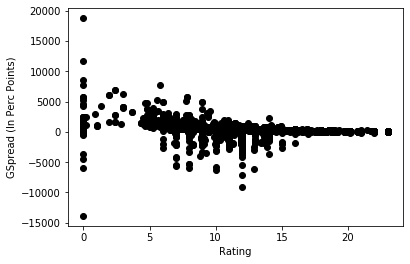

In [28]:
X = df_securities_US_w_data_clean[["RatingSP","GSpread"]]
#Visualise data points
plt.scatter(X["RatingSP"],X["GSpread"],c='black')
plt.xlabel('Rating')
plt.ylabel('GSpread (In Perc Points)')
plt.show()

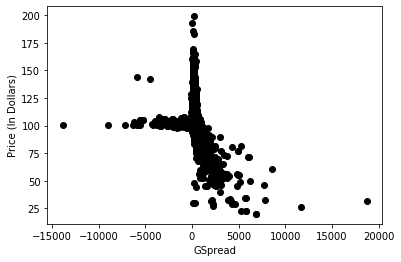

In [31]:
X = df_securities_US_w_data_clean[["GSpread","Price"]]
#Visualise data points
plt.scatter(X["GSpread"],X["Price"],c='black')
plt.xlabel('GSpread')
plt.ylabel('Price (In Dollars)')
plt.show()

[array([[3.58639053e+04, 2.19677722e+02, 1.45647389e+01]]), array([[1.81838585e+04, 1.72535637e+02, 1.54201273e+01],
       [5.36979949e+04, 2.67230546e+02, 1.37018977e+01]]), array([[6.13707985e+04, 3.00090029e+02, 1.36166049e+01],
       [1.44089360e+04, 1.71442199e+02, 1.57755216e+01],
       [4.11904428e+04, 2.13905581e+02, 1.38861366e+01]]), array([[1.03492046e+04, 1.79629056e+02, 1.57453406e+01],
       [4.68050773e+04, 2.21831812e+02, 1.38572982e+01],
       [6.42976170e+04, 3.37042701e+02, 1.34629297e+01],
       [2.62781100e+04, 1.65207181e+02, 1.50841381e+01]]), array([[6.58491619e+04, 3.43155704e+02, 1.34852405e+01],
       [1.90633551e+04, 1.61508565e+02, 1.61375577e+01],
       [3.59111371e+04, 2.04043524e+02, 1.38327761e+01],
       [5.01482392e+04, 2.27400460e+02, 1.39126860e+01],
       [6.42131608e+03, 1.88601309e+02, 1.51677361e+01]]), array([[3.14366671e+04, 1.73838506e+02, 1.42572529e+01],
       [4.30547515e+04, 2.29599391e+02, 1.34950465e+01],
       [6.27670313e+

NameError: name 'order_centroids' is not defined

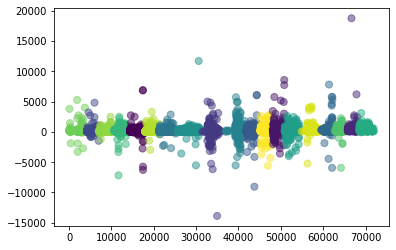

In [56]:
K = range(1,20)
df = df_securities_US_w_data_clean[['SecurityID','GSpread','RatingSP']]


fits = [KMeans(n_clusters=k, init='k-means++', max_iter=500, 
               n_init=30, verbose=False, random_state=42).fit(df) for k in K]
centroids = [fit.cluster_centers_ for fit in fits]
inertias = [fit.inertia_ for fit in fits]



print(centroids)


plt.scatter(df['SecurityID'], df['GSpread'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(order_centroids[:, 0], order_centroids[:, 1], c='red', s=50)
plt.show()
